In [2]:
# ==================== STEP 0: SETUP & CONFIGURATION ====================
import warnings
warnings.filterwarnings('ignore')

import sys
import os
import logging
from pathlib import Path
import json
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import joblib
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import xgboost as xgb

# Configuration
RANDOM_SEED = 42
SEQ_LEN = 30
BATCH_SIZE = 256
CLIP_MAX = 125
ID_COL = "engine_id_global" # Global unique ID across subsets
TARGET = "RUL_clip"
TIME_COL = "cycle"

# Setup Project Root
try:
    PROJECT_ROOT = Path.cwd()
    while not (PROJECT_ROOT / 'src').exists() and PROJECT_ROOT.parent != PROJECT_ROOT:
        PROJECT_ROOT = PROJECT_ROOT.parent
except:
    PROJECT_ROOT = Path.cwd()

# Define Paths
DATA_DIR = PROJECT_ROOT / "data" / "raw" / "CMAPSS"
PROCESSED_DIR = PROJECT_ROOT / "data" / "processed"
MODELS_DIR = PROJECT_ROOT / "models"
SUBSETS = ["FD001", "FD002", "FD003", "FD004"]

# Ensure directories exist
for d in [PROCESSED_DIR, MODELS_DIR]:
    d.mkdir(parents=True, exist_ok=True)

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger('notebook')
print(f"✅ Project Root: {PROJECT_ROOT}")
print(f"✅ Device: {device}")


✅ Project Root: /Users/xe/Documents/GITHUB CAPSTONE /Agentic-Early-Warning-Intelligence-System-for-Silent-System-Failures
✅ Device: mps


In [3]:
# ==================== STEP 1: DATA LOADING (STRICT) ====================
def load_data():
    logger.info("🚀 Loading C-MAPSS Data with Strict Validation...")
    col_names = ['engine_id', 'cycle', 'op_setting_1', 'op_setting_2', 'op_setting_3'] + \
                [f'sensor_{i}' for i in range(1, 22)]
    
    list_train, list_test = [], []
    
    # 1. Validation Loop
    missing_files = []
    for subset in SUBSETS:
        for ftype in ["train", "test", "RUL"]:
            fname = f"{ftype}_{subset}.txt"
            if not (DATA_DIR / fname).exists():
                missing_files.append(fname)
                
    if missing_files:
        raise FileNotFoundError(f"❌ CRITICAL: Missing required files: {missing_files}")
    else:
        print("✅ All 12/12 C-MAPSS files verified.")

    # 2. Loading Loop (Robust)
    for subset in SUBSETS:
        # Load Train
        df_tr = pd.read_csv(DATA_DIR / f"train_{subset}.txt", sep=r"\s+", header=None)
        df_tr = df_tr.iloc[:, :len(col_names)] # STRICT SLICING
        df_tr.columns = col_names
        
        # Load Test
        df_te = pd.read_csv(DATA_DIR / f"test_{subset}.txt", sep=r"\s+", header=None)
        df_te = df_te.iloc[:, :len(col_names)] # STRICT SLICING
        df_te.columns = col_names
        
        # Create Unique Global IDs (subset + engine_id)
        df_tr[ID_COL] = f"{subset}_" + df_tr['engine_id'].astype(str)
        df_te[ID_COL] = f"{subset}_" + df_te['engine_id'].astype(str)
        
        df_tr['dataset_id'] = subset
        df_te['dataset_id'] = subset
        
        list_train.append(df_tr)
        list_test.append(df_te)
        
    return pd.concat(list_train, ignore_index=True), pd.concat(list_test, ignore_index=True)

train_all, test_all = load_data()
print(f"✅ Loaded Train: {train_all.shape}, Test: {test_all.shape}")


INFO:notebook:🚀 Loading C-MAPSS Data with Strict Validation...


✅ All 12/12 C-MAPSS files verified.
✅ Loaded Train: (160359, 28), Test: (104897, 28)


In [4]:
# ==================== STEP 2: RUL LABEL CREATION (FIXED) ====================
def create_labels(train_df, test_df):
    logger.info("🚀 Creating RUL Labels with Strict ID Mapping...")
    
    # 1. Train RUL (Linear degradation)
    max_cycle = train_df.groupby(ID_COL)[TIME_COL].max().rename('max_cycle')
    train_df = train_df.merge(max_cycle, on=ID_COL)
    train_df['RUL'] = train_df['max_cycle'] - train_df[TIME_COL]
    train_df[TARGET] = train_df['RUL'].clip(upper=CLIP_MAX)
    
    # 2. Test RUL (Using Ground Truth Files)
    rul_list = []
    for subset in SUBSETS:
        # Robust Reading
        try:
            df_rul = pd.read_csv(DATA_DIR / f"RUL_{subset}.txt", sep=r'\s+', header=None, names=['RUL_end'])
        except:
             df_rul = pd.read_csv(DATA_DIR / f"RUL_{subset}.txt", header=None, names=['RUL_end'])
        
        # Robust ID Creation (Using explicit Index)
        df_rul['dataset_id'] = subset
        df_rul['engine_id_index'] = df_rul.index + 1
        df_rul[ID_COL] = df_rul['dataset_id'] + "_" + df_rul['engine_id_index'].astype(str)
        
        rul_list.append(df_rul[[ID_COL, 'RUL_end']])
        
    all_ruls = pd.concat(rul_list, ignore_index=True)
    test_df = test_df.merge(all_ruls, on=ID_COL, how='left')
    
    # Check for unmapped RULs
    missing_ruls = test_df['RUL_end'].isnull().sum()
    if missing_ruls > 0:
        raise ValueError(f"❌ CRITICAL: Failed to map {missing_ruls} test engines to RUL file!")
        
    # Calculate RUL at each time step for Test
    max_cycle_test = test_df.groupby(ID_COL)[TIME_COL].max().rename('max_cycle')
    test_df = test_df.merge(max_cycle_test, on=ID_COL)
    test_df['RUL'] = test_df['RUL_end'] + (test_df['max_cycle'] - test_df[TIME_COL])
    test_df[TARGET] = test_df['RUL'].clip(upper=CLIP_MAX)
    
    return train_df, test_df

full_train_df, full_test_df = create_labels(train_all, test_all)
print("✅ Labels Created and Verified.")

INFO:notebook:🚀 Creating RUL Labels with Strict ID Mapping...


✅ Labels Created and Verified.


In [5]:
# ==================== STEP 3: FEATURE ENGINEERING (SORTED & FIXED) ====================
def process_data_pipeline(full_train, full_test):
    logger.info("🚀 Feature Engineering (Sorted & Leakage-Free)...")
    
    # --- 1. Feature Selection (CRITICAL FIX) ---
    meta_cols = [ID_COL, TIME_COL, 'RUL', TARGET, 'max_cycle', 'RUL_end', 'dataset_id', 'engine_id', 'label_fail', 'engine_id_index']
    available_cols = [c for c in full_train.columns if c not in meta_cols]
    print(f"✅ Features Selected ({len(available_cols)}): {available_cols}")
    
    # Save Feature List
    import json
    with open(MODELS_DIR / 'features.json', 'w') as f:
        json.dump(available_cols, f)
    
    # --- 2. Train/Val Split (by Engine) ---
    unique_engines = full_train[ID_COL].unique()
    train_ids, val_ids = train_test_split(unique_engines, test_size=0.2, random_state=RANDOM_SEED)
    
    train_df = full_train[full_train[ID_COL].isin(train_ids)].copy()
    val_df = full_train[full_train[ID_COL].isin(val_ids)].copy()
    
    # SORTING CRITICAL for Sliding Window
    train_df = train_df.sort_values([ID_COL, TIME_COL])
    val_df = val_df.sort_values([ID_COL, TIME_COL])
    full_test = full_test.sort_values([ID_COL, TIME_COL])
    
    print(f"✅ Data Sorted by Engine and Time.")
    
    # --- 3. Scaling (per-subset, with per-regime normalization for FD002/FD004) ---
    # FD001/FD003 have 1 operating condition → global scaling is fine.
    # FD002/FD004 have 6 operating regimes → per-regime scaling prevents
    # blending regime differences with degradation signal.
    from sklearn.cluster import KMeans
    
    MULTI_COND = {'FD002', 'FD004'}
    N_REGIMES = 6
    op_cols = ['op_setting_1', 'op_setting_2', 'op_setting_3']
    
    scaled_train_pieces, scaled_val_pieces, scaled_test_pieces = [], [], []
    scalers_dict = {}   # for optional persistence
    
    for subset in SUBSETS:
        tr = train_df[train_df['dataset_id'] == subset].copy()
        va = val_df[val_df['dataset_id'] == subset].copy()
        te = full_test[full_test['dataset_id'] == subset].copy()
        
        if subset in MULTI_COND:
            # Cluster operating regimes on training op_settings
            km = KMeans(n_clusters=N_REGIMES, random_state=42, n_init=10)
            km.fit(tr[op_cols])
            
            tr_labels = km.predict(tr[op_cols])
            va_labels = km.predict(va[op_cols]) if len(va) > 0 else np.array([])
            te_labels = km.predict(te[op_cols]) if len(te) > 0 else np.array([])
            
            # Scale per-regime: fit on train, transform val/test with same scaler
            regime_scalers = {}
            for r in range(N_REGIMES):
                tr_mask = tr_labels == r
                if tr_mask.any():
                    sc_r = StandardScaler()
                    tr.loc[tr.index[tr_mask], available_cols] = sc_r.fit_transform(
                        tr.loc[tr.index[tr_mask], available_cols]
                    )
                    regime_scalers[r] = sc_r
                    
                    if len(va_labels) > 0:
                        va_mask = va_labels == r
                        if va_mask.any():
                            va.loc[va.index[va_mask], available_cols] = sc_r.transform(
                                va.loc[va.index[va_mask], available_cols]
                            )
                    if len(te_labels) > 0:
                        te_mask = te_labels == r
                        if te_mask.any():
                            te.loc[te.index[te_mask], available_cols] = sc_r.transform(
                                te.loc[te.index[te_mask], available_cols]
                            )
            scalers_dict[subset] = {'kmeans': km, 'regime_scalers': regime_scalers}
            print(f"  ✅ {subset}: per-regime scaling ({N_REGIMES} regimes)")
        else:
            # Single operating condition — global scaling
            sc = StandardScaler()
            tr[available_cols] = sc.fit_transform(tr[available_cols])
            if len(va) > 0:
                va[available_cols] = sc.transform(va[available_cols])
            te[available_cols] = sc.transform(te[available_cols])
            scalers_dict[subset] = {'scaler': sc}
            print(f"  ✅ {subset}: global scaling")
        
        scaled_train_pieces.append(tr)
        scaled_val_pieces.append(va)
        scaled_test_pieces.append(te)
    
    train_df = pd.concat(scaled_train_pieces, ignore_index=True)
    val_df   = pd.concat(scaled_val_pieces, ignore_index=True)
    full_test = pd.concat(scaled_test_pieces, ignore_index=True)
    
    # Save Scalers
    try:
        joblib.dump(scalers_dict, MODELS_DIR / 'scalers_per_subset.joblib')
        print("✅ Per-subset scalers saved.")
    except:
        pass
    
    # --- 4. Sliding Window Sequence Generation ---
    def create_sequences(df):
        X, y = [], []
        engine_uids, time_cycles = [], []
        
        for engine_id, engine_data in df.groupby(ID_COL, sort=False):
            if len(engine_data) < SEQ_LEN: continue
            
            vals = engine_data[available_cols].values
            targs = engine_data[TARGET].values
            cycles = engine_data[TIME_COL].values
            
            for i in range(len(engine_data) - SEQ_LEN + 1):
                X.append(vals[i : i + SEQ_LEN])
                y.append(targs[i + SEQ_LEN - 1])
                engine_uids.append(engine_id)
                time_cycles.append(cycles[i + SEQ_LEN - 1])
                
        return np.array(X, dtype=np.float32), np.array(y, dtype=np.float32), np.array(engine_uids), np.array(time_cycles)

    print("⏳ Creating Sequences...")
    X_train, y_train, _, _ = create_sequences(train_df)
    X_val, y_val, _, _ = create_sequences(val_df)
    
    X_test_all, y_test_all, test_engine_ids, test_cycles = create_sequences(full_test)

    # Save processed data for Phase 4 & 5
    np.save(PROCESSED_DIR / 'X_train.npy', X_train)
    np.save(PROCESSED_DIR / 'y_train.npy', y_train)
    np.save(PROCESSED_DIR / 'X_val.npy', X_val)
    np.save(PROCESSED_DIR / 'y_val.npy', y_val)
    np.save(PROCESSED_DIR / 'X_test.npy', X_test_all)
    np.save(PROCESSED_DIR / 'y_test.npy', y_test_all)
    
    # SAVE METADATA (CRITICAL FOR LIFECYCLE PLOT)
    np.save(PROCESSED_DIR / 'test_engine_uid.npy', test_engine_ids)
    np.save(PROCESSED_DIR / 'test_cycle_end.npy', test_cycles)
    print(f"✅ Saved X_train, X_val, X_test, metadata to {PROCESSED_DIR}")

    # Test Data Last: last window per engine + per-engine subset tag for per-subset eval
    X_test_last, y_test_last, test_engine_ids_last = [], [], []
    for engine_id, engine_data in full_test.groupby(ID_COL, sort=False):
        if len(engine_data) >= SEQ_LEN:
            X_test_last.append(engine_data[available_cols].values[-SEQ_LEN:])
            y_test_last.append(engine_data[TARGET].values[-1])
            # Extract subset tag e.g. "FD001" from "FD001_1"
            test_engine_ids_last.append(engine_id.split('_')[0])
            
    X_test_last = np.array(X_test_last, dtype=np.float32)
    y_test_last = np.array(y_test_last, dtype=np.float32)
    test_engine_ids_last = np.array(test_engine_ids_last)
    
    return X_train, y_train, X_val, y_val, X_test_last, y_test_last, available_cols, test_engine_ids_last

X_train, y_train, X_val, y_val, X_test_last, y_test_last, features, test_engine_ids_last = process_data_pipeline(full_train_df, full_test_df)
print(f"✅ Sequences: Train {X_train.shape}, Val {X_val.shape}, Test Last {X_test_last.shape}")
print(f"✅ Per-subset engines in last-cycle test: { {s: int((test_engine_ids_last==s).sum()) for s in ['FD001','FD002','FD003','FD004']} }")

# Prepare Flattened Data for Baselines (Take last step of sequence)
X_train_flat = X_train[:, -1, :]
X_val_flat = X_val[:, -1, :]
X_test_last_flat = X_test_last[:, -1, :]


INFO:notebook:🚀 Feature Engineering (Sorted & Leakage-Free)...


✅ Features Selected (24): ['op_setting_1', 'op_setting_2', 'op_setting_3', 'sensor_1', 'sensor_2', 'sensor_3', 'sensor_4', 'sensor_5', 'sensor_6', 'sensor_7', 'sensor_8', 'sensor_9', 'sensor_10', 'sensor_11', 'sensor_12', 'sensor_13', 'sensor_14', 'sensor_15', 'sensor_16', 'sensor_17', 'sensor_18', 'sensor_19', 'sensor_20', 'sensor_21']
✅ Data Sorted by Engine and Time.
  ✅ FD001: global scaling
  ✅ FD002: per-regime scaling (6 regimes)
  ✅ FD003: global scaling
  ✅ FD004: per-regime scaling (6 regimes)
✅ Per-subset scalers saved.
⏳ Creating Sequences...
✅ Saved X_train, X_val, X_test, metadata to /Users/xe/Documents/GITHUB CAPSTONE /Agentic-Early-Warning-Intelligence-System-for-Silent-System-Failures/data/processed
✅ Sequences: Train (112876, 30, 24), Val (26922, 30, 24), Test Last (690, 30, 24)
✅ Per-subset engines in last-cycle test: {'FD001': 100, 'FD002': 253, 'FD003': 100, 'FD004': 237}


In [6]:
# ==================== STEP 4: BASELINE MODELS (RF, GB, XGB) ====================
print("\n🚀 Training Baseline Models...")
baseline_results = {}

models = {
    "Random Forest": RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=RANDOM_SEED),
    "XGBoost": xgb.XGBRegressor(n_estimators=100, n_jobs=-1, random_state=RANDOM_SEED),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, random_state=RANDOM_SEED)
}

for name, model in models.items():
    print(f"   Training {name}...")
    model.fit(X_train_flat, y_train)
    
    # Predict Train
    y_pred_train = model.predict(X_train_flat)
    rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
    
    # Predict Val
    y_pred_val = model.predict(X_val_flat)
    rmse_val = np.sqrt(mean_squared_error(y_val, y_pred_val))
    
    # Predict Test
    y_pred_test = model.predict(X_test_last_flat)
    rmse_test = np.sqrt(mean_squared_error(y_test_last, y_pred_test))
    
    baseline_results[name] = {"Train RMSE": rmse_train, "Val RMSE": rmse_val, "Test RMSE": rmse_test}
    print(f"   ✅ {name:20} | Train: {rmse_train:.2f} | Val: {rmse_val:.2f} | Test: {rmse_test:.2f}")

# Save Best Model Logic (e.g. XGBoost)
try:
    best_xgb = models["XGBoost"]
    joblib.dump(best_xgb, MODELS_DIR / "xgb_model.joblib")
    print("✅ Saved XGBoost Model.")
except:
    pass


🚀 Training Baseline Models...
   Training Random Forest...
   ✅ Random Forest        | Train: 7.10 | Val: 20.71 | Test: 19.27
   Training XGBoost...
   ✅ XGBoost              | Train: 16.65 | Val: 20.71 | Test: 19.13
   Training Gradient Boosting...
   ✅ Gradient Boosting    | Train: 19.05 | Val: 20.91 | Test: 19.48
✅ Saved XGBoost Model.


In [10]:
# ==================== STEP 6A: LSTM TRAINING (IMPROVED) ====================
print("\n🚀 Training LSTM...")

# Data Loaders
lstm_train_dataset = TensorDataset(torch.FloatTensor(X_train), torch.FloatTensor(y_train))
lstm_val_dataset = TensorDataset(torch.FloatTensor(X_val), torch.FloatTensor(y_val))

train_loader = DataLoader(lstm_train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(lstm_val_dataset, batch_size=BATCH_SIZE, shuffle=False)

class LSTMRULModel(nn.Module):
    def __init__(self, input_dim, hidden_dim=100, num_layers=2, output_dim=1):
        super(LSTMRULModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, dropout=0.2)
        self.fc = nn.Linear(hidden_dim, output_dim)
        # NOTE: No output activation — ReLU was removed because it floors
        # predictions at 0, biasing gradients and inflating residuals (~60 cycles).
        # Targets are already clipped to [0, 125]; MSE loss is sufficient.
        
    def forward(self, x):
        out, _ = self.lstm(x)
        out_last = out[:, -1, :]
        return self.fc(out_last)

lstm = LSTMRULModel(input_dim=X_train.shape[2]).to(device)
opt = torch.optim.Adam(lstm.parameters(), lr=0.001)
crit = nn.MSELoss()

# --- Training improvements ---
# 1. LR Scheduler: halve LR when val loss plateaus for 5 epochs
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, mode='min', factor=0.5, patience=5)
# 2. Gradient clipping max norm
GRAD_CLIP = 1.0
# 3. Early stopping patience
EARLY_STOP_PATIENCE = 30

best_val_loss = float('inf')
epochs_no_improve = 0
EPOCHS = 60

print(f"   Config: epochs={EPOCHS}, lr=0.001, grad_clip={GRAD_CLIP}, "
      f"scheduler_patience=5, early_stop={EARLY_STOP_PATIENCE}")

for epoch in range(EPOCHS):
    lstm.train()
    train_loss = 0.0
    for x_batch, y_batch in train_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device).unsqueeze(1)
        opt.zero_grad()
        loss = crit(lstm(x_batch), y_batch)
        loss.backward()
        # Gradient clipping to prevent exploding gradients in LSTM
        torch.nn.utils.clip_grad_norm_(lstm.parameters(), GRAD_CLIP)
        opt.step()
        train_loss += loss.item()
    
    # Validation
    lstm.eval()
    val_loss = 0.0
    with torch.no_grad():
        for xv_batch, yv_batch in val_loader:
            xv_batch, yv_batch = xv_batch.to(device), yv_batch.to(device).unsqueeze(1)
            val_loss += crit(lstm(xv_batch), yv_batch).item()
            
    train_loss /= len(train_loader)
    val_loss /= len(val_loader)
    
    # Step the LR scheduler based on validation loss
    scheduler.step(val_loss)
    current_lr = opt.param_groups[0]['lr']
    
    # Save Best Model + Early Stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
        torch.save(lstm.state_dict(), MODELS_DIR / "lstm_best.pth")
    else:
        epochs_no_improve += 1
    
    if (epoch + 1) % 5 == 0 or epoch == 0 or epochs_no_improve == 0:
        print(f"   Epoch {epoch+1:02d}/{EPOCHS} | Train Loss: {train_loss:.2f} | Val Loss: {val_loss:.2f} | LR: {current_lr:.6f} | Best: {best_val_loss:.2f}")
    
    if epochs_no_improve >= EARLY_STOP_PATIENCE:
        print(f"   ⏹️ Early stopping at epoch {epoch+1} (no improvement for {EARLY_STOP_PATIENCE} epochs)")
        break

print(f"   ✅ Training complete. Best Val Loss: {best_val_loss:.2f}")

# Final Eval Metrics
lstm.load_state_dict(torch.load(MODELS_DIR / "lstm_best.pth", map_location=device, weights_only=True))
lstm.eval()
with torch.no_grad():
    # Train Eval — batched to avoid OOM
    y_pred_train_list = []
    temp_train_loader = DataLoader(lstm_train_dataset, batch_size=BATCH_SIZE, shuffle=False)
    for x_b, _ in temp_train_loader:
        y_pred_train_list.append(lstm(x_b.to(device)).cpu())
    y_pred_train = torch.cat(y_pred_train_list).numpy().flatten()
    lstm_rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))

    # Val Eval
    y_pred_val_list = []
    for x_b, _ in val_loader:
        y_pred_val_list.append(lstm(x_b.to(device)).cpu())
    y_pred_val = torch.cat(y_pred_val_list).numpy().flatten()
    lstm_rmse_val = np.sqrt(mean_squared_error(y_val, y_pred_val))

    # Test Eval (Last window per engine)
    y_pred_test = lstm(torch.FloatTensor(X_test_last).to(device)).cpu().numpy().flatten()
    lstm_rmse_test = np.sqrt(mean_squared_error(y_test_last, y_pred_test))
    
    print(f"✅ LSTM Final Metrics: Train RMSE: {lstm_rmse_train:.2f} | Val RMSE: {lstm_rmse_val:.2f} | Test RMSE: {lstm_rmse_test:.2f}")


🚀 Training LSTM...
   Config: epochs=60, lr=0.001, grad_clip=1.0, scheduler_patience=5, early_stop=30
   Epoch 01/60 | Train Loss: 5438.95 | Val Loss: 2812.49 | LR: 0.001000 | Best: 2812.49
   Epoch 02/60 | Train Loss: 1558.60 | Val Loss: 564.98 | LR: 0.001000 | Best: 564.98
   Epoch 03/60 | Train Loss: 307.99 | Val Loss: 252.42 | LR: 0.001000 | Best: 252.42
   Epoch 04/60 | Train Loss: 197.09 | Val Loss: 241.50 | LR: 0.001000 | Best: 241.50
   Epoch 05/60 | Train Loss: 178.58 | Val Loss: 237.72 | LR: 0.001000 | Best: 237.72
   Epoch 10/60 | Train Loss: 118.33 | Val Loss: 283.11 | LR: 0.001000 | Best: 237.72
   Epoch 15/60 | Train Loss: 65.95 | Val Loss: 313.10 | LR: 0.000500 | Best: 237.72
   Epoch 20/60 | Train Loss: 43.10 | Val Loss: 343.89 | LR: 0.000250 | Best: 237.72
   Epoch 25/60 | Train Loss: 34.12 | Val Loss: 355.69 | LR: 0.000125 | Best: 237.72
   Epoch 30/60 | Train Loss: 29.90 | Val Loss: 354.84 | LR: 0.000063 | Best: 237.72
   Epoch 35/60 | Train Loss: 28.08 | Val Loss: 

In [ ]:
# ==================== STEP 6B: TCN TRAINING (IMPROVED) ====================
print("\n🚀 Training TCN...")

# 1. Define TCN Data Loaders (Isolated from LSTM)
tcn_train_loader = DataLoader(TensorDataset(torch.FloatTensor(X_train), torch.FloatTensor(y_train)), 
                         batch_size=BATCH_SIZE, shuffle=True)
tcn_val_loader = DataLoader(TensorDataset(torch.FloatTensor(X_val), torch.FloatTensor(y_val)), 
                         batch_size=BATCH_SIZE, shuffle=False)

class TCNModel(nn.Module):
    def __init__(self, input_dim):
        super(TCNModel, self).__init__()
        # Simple TCN-like structure with 1D Convs
        # ReLU is used in HIDDEN layers only (fine for feature extraction).
        # Final layer is Linear(32,1) with NO output activation.
        self.net = nn.Sequential(
            nn.Conv1d(input_dim, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Conv1d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Conv1d(64, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1), # Global Pooling
            nn.Flatten(),
            nn.Linear(32, 1)
        )
    def forward(self, x):
        # x: (Batch, Seq, Feat) -> (Batch, Feat, Seq) for Conv1d
        return self.net(x.transpose(1, 2))

tcn = TCNModel(input_dim=X_train.shape[2]).to(device)
opt_tcn = torch.optim.Adam(tcn.parameters(), lr=0.001)
crit = nn.MSELoss()

# --- Training improvements (same as LSTM) ---
scheduler_tcn = torch.optim.lr_scheduler.ReduceLROnPlateau(opt_tcn, mode='min', factor=0.5, patience=5)
GRAD_CLIP_TCN = 1.0
EARLY_STOP_PATIENCE_TCN = 12

best_val_loss_tcn = float('inf')
epochs_no_improve_tcn = 0
EPOCHS = 60

print(f"   Config: epochs={EPOCHS}, lr=0.001, grad_clip={GRAD_CLIP_TCN}, "
      f"scheduler_patience=5, early_stop={EARLY_STOP_PATIENCE_TCN}")
print(f"   Training on {len(tcn_train_loader)} batches...")

for epoch in range(EPOCHS):
    tcn.train()
    train_loss = 0.0
    
    # CRITICAL: Use tcn_train_loader, NOT train_loader
    for x_batch, y_batch in tcn_train_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device).unsqueeze(1)
        opt_tcn.zero_grad()
        loss = crit(tcn(x_batch), y_batch)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(tcn.parameters(), GRAD_CLIP_TCN)
        opt_tcn.step()
        train_loss += loss.item()
    
    # Validation
    tcn.eval()
    val_loss = 0.0
    with torch.no_grad():
        for xv_batch, yv_batch in tcn_val_loader:
            xv_batch, yv_batch = xv_batch.to(device), yv_batch.to(device).unsqueeze(1)
            val_loss += crit(tcn(xv_batch), yv_batch).item()
            
    train_loss /= len(tcn_train_loader)
    val_loss /= len(tcn_val_loader)
    
    # Step the LR scheduler
    scheduler_tcn.step(val_loss)
    current_lr = opt_tcn.param_groups[0]['lr']
    
    # Save Best Model + Early Stopping
    if val_loss < best_val_loss_tcn:
        best_val_loss_tcn = val_loss
        epochs_no_improve_tcn = 0
        torch.save(tcn.state_dict(), MODELS_DIR / "tcn_best.pth")
    else:
        epochs_no_improve_tcn += 1
    
    if (epoch + 1) % 5 == 0 or epoch == 0 or epochs_no_improve_tcn == 0:
        print(f"   Epoch {epoch+1:02d}/{EPOCHS} | Train Loss: {train_loss:.2f} | Val Loss: {val_loss:.2f} | LR: {current_lr:.6f} | Best: {best_val_loss_tcn:.2f}")
    
    if epochs_no_improve_tcn >= EARLY_STOP_PATIENCE_TCN:
        print(f"   ⏹️ Early stopping at epoch {epoch+1} (no improvement for {EARLY_STOP_PATIENCE_TCN} epochs)")
        break

print(f"   ✅ Training complete. Best Val Loss: {best_val_loss_tcn:.2f}")

# Final Eval Metrics
tcn.load_state_dict(torch.load(MODELS_DIR / "tcn_best.pth", map_location=device, weights_only=True))
tcn.eval()
with torch.no_grad():
    # Train Eval
    y_pred_train_list = []
    temp_tcn_train_loader = DataLoader(TensorDataset(torch.FloatTensor(X_train), torch.FloatTensor(y_train)), batch_size=BATCH_SIZE, shuffle=False)
    for x_b, _ in temp_tcn_train_loader:
        y_pred_train_list.append(tcn(x_b.to(device)).cpu())
    y_pred_train = torch.cat(y_pred_train_list).numpy().flatten()
    tcn_rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))

    # Val Eval
    y_pred_val_list = []
    for x_b, _ in tcn_val_loader:
        y_pred_val_list.append(tcn(x_b.to(device)).cpu())
    y_pred_val = torch.cat(y_pred_val_list).numpy().flatten()
    tcn_rmse_val = np.sqrt(mean_squared_error(y_val, y_pred_val))

    # Test Eval (Last window per engine)
    y_pred_test = tcn(torch.FloatTensor(X_test_last).to(device)).cpu().numpy().flatten()
    tcn_rmse_test = np.sqrt(mean_squared_error(y_test_last, y_pred_test))
    
    print(f"✅ TCN Final Metrics: Train RMSE: {tcn_rmse_train:.2f} | Val RMSE: {tcn_rmse_val:.2f} | Test RMSE: {tcn_rmse_test:.2f}")


🚀 Training TCN...


TypeError: ReduceLROnPlateau.__init__() got an unexpected keyword argument 'verbose'


📊 FINAL SUMMARY (RMSE - Lower is Better)
-----------------------------------------------------------------
Model                | Train      | Val        | Test (Last Cycle)
-----------------------------------------------------------------
Random Forest        | 6.95       | 20.36      | 18.39     
XGBoost              | 16.97      | 20.44      | 18.71     
Gradient Boosting    | 20.09      | 21.56      | 19.75     
LSTM                 | 19.96      | 22.66      | 33.28     
TCN                  | 21.19      | 22.90      | 22.80     

Model                | FD001 RMSE | FD002 RMSE | FD003 RMSE | FD004 RMSE |   NASA Score
Random Forest        |      17.23 |      17.30 |      19.06 |      19.66 |       6781.2
XGBoost              |      17.21 |      17.63 |      19.42 |      20.08 |       7809.9
Gradient Boosting    |      16.64 |      18.83 |      20.51 |      21.51 |       7326.8
LSTM                 |      34.29 |      30.94 |      35.41 |      34.30 |      64709.1
TCN               

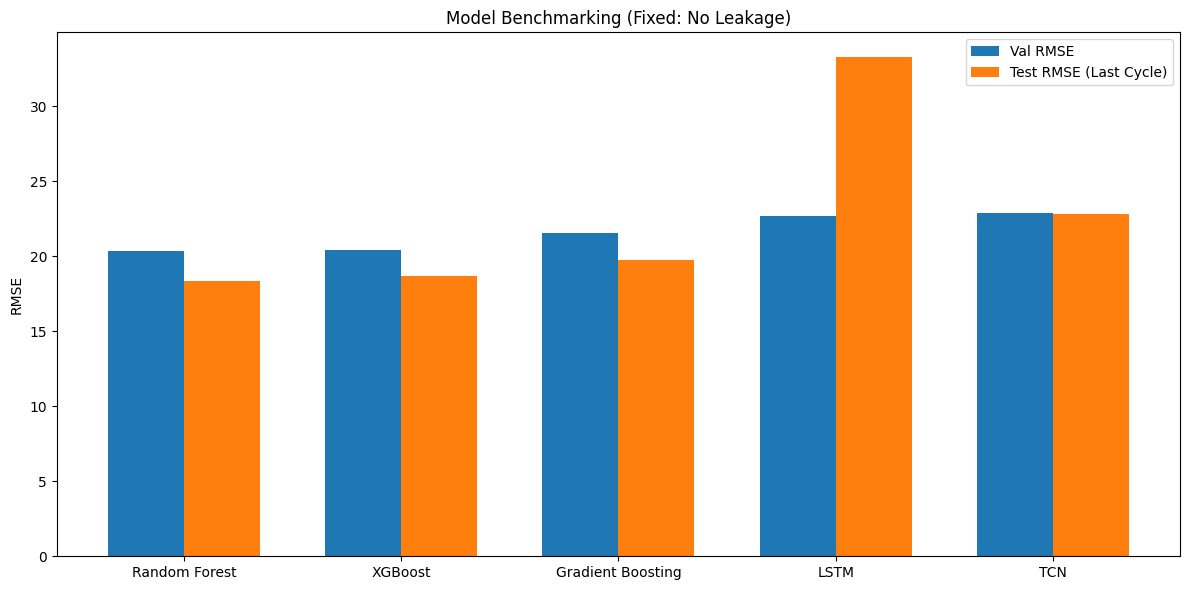

In [ ]:
# ==================== STEP 7: FINAL COMPARISON ====================

# --- NASA Score: C-MAPSS asymmetric benchmark metric ---
# Penalty for late predictions (d>0) uses exp(d/10); early (d<0) uses exp(-d/13)
# Lower is better.
def nasa_score(y_true, y_pred):
    d = np.asarray(y_pred, float) - np.asarray(y_true, float)
    return float(np.sum(np.where(d < 0, np.exp(-d / 13) - 1, np.exp(d / 10) - 1)))

# --- Wrap PyTorch models with a sklearn-compatible .predict() ---
class TorchPredictor:
    """Thin wrapper so LSTM/TCN can share the same predict() interface."""
    def __init__(self, model, device):
        self.model = model
        self.device = device
    def predict(self, X):
        self.model.eval()
        with torch.no_grad():
            return self.model(torch.FloatTensor(X).to(self.device)).cpu().numpy().flatten()

# --- Build unified model registry ---
# Baselines use X_test_last_flat (2-D); Torch models use X_test_last (3-D)
all_models_flat = dict(models)   # RF, XGBoost, GradientBoosting (already trained)
all_models_seq  = {}             # LSTM, TCN
if 'lstm' in vars() and lstm is not None:
    try:    all_models_seq['LSTM'] = TorchPredictor(lstm, device)
    except: pass
if 'tcn' in vars() and tcn is not None:
    try:    all_models_seq['TCN'] = TorchPredictor(tcn, device)
    except: pass

# --- Overall RMSE summary table ---
print('\n📊 FINAL SUMMARY (RMSE - Lower is Better)')
print('-' * 65)
print(f"{'Model':<20} | {'Train':<10} | {'Val':<10} | {'Test (Last Cycle)':<10}")
print('-' * 65)

for m in baseline_results:
    print(f"{m:<20} | {baseline_results[m]['Train RMSE']:<10.2f} | {baseline_results[m]['Val RMSE']:<10.2f} | {baseline_results[m]['Test RMSE']:<10.2f}")

def get_metric(prefix, metric_type):
    var_names = [f'{prefix}_rmse_{metric_type}', f'{prefix}_{metric_type}_rmse']
    for v in var_names:
        if v in globals():
            return globals()[v]
    return None

l_train = get_metric('lstm', 'train'); l_val = get_metric('lstm', 'val'); l_test = get_metric('lstm', 'test')
t_train = get_metric('tcn',  'train'); t_val = get_metric('tcn',  'val'); t_test = get_metric('tcn',  'test')

if l_train is not None:
    print(f"{'LSTM':<20} | {l_train:<10.2f} | {l_val:<10.2f} | {l_test:<10.2f}")
else:
    print(f"{'LSTM':<20} | {'N/A':<10} | {'N/A':<10} | {'N/A':<10}")
if t_train is not None:
    print(f"{'TCN':<20} | {t_train:<10.2f} | {t_val:<10.2f} | {t_test:<10.2f}")
else:
    print(f"{'TCN':<20} | {'N/A':<10} | {'N/A':<10} | {'N/A':<10}")

# --- Per-subset RMSE + NASA Score table ---
print('\n' + '=' * 105)
print(f"{'Model':<20} | {'FD001 RMSE':>10} | {'FD002 RMSE':>10} | {'FD003 RMSE':>10} | {'FD004 RMSE':>10} | {'NASA Score':>12}")
print('=' * 105)

def _eval_subset_table(model_dict, X_input):
    for mname, model in model_dict.items():
        row = f'{mname:<20}'
        for sub in ['FD001', 'FD002', 'FD003', 'FD004']:
            mask = test_engine_ids_last == sub
            if mask.sum() == 0:
                row += f" | {'N/A':>10}"
                continue
            y_pred_sub = model.predict(X_input[mask])
            rmse = np.sqrt(mean_squared_error(y_test_last[mask], y_pred_sub))
            row += f' | {rmse:>10.2f}'
        y_pred_all = model.predict(X_input)
        row += f' | {nasa_score(y_test_last, y_pred_all):>12.1f}'
        print(row)

_eval_subset_table(all_models_flat, X_test_last_flat)
_eval_subset_table(all_models_seq,  X_test_last)
print('=' * 105)
print('NASA Score: lower is better  |  late predictions penalised 10x harder than early ones')

# --- Bar chart ---
models_final = list(baseline_results.keys())
val_scores   = [baseline_results[m]['Val RMSE']  for m in baseline_results]
test_scores  = [baseline_results[m]['Test RMSE'] for m in baseline_results]

if l_val is not None:
    models_final.append('LSTM'); val_scores.append(l_val); test_scores.append(l_test)
if t_val is not None:
    models_final.append('TCN');  val_scores.append(t_val); test_scores.append(t_test)

plt.figure(figsize=(12, 6))
x = np.arange(len(models_final))
width = 0.35
plt.bar(x - width/2, val_scores,  width, label='Val RMSE')
plt.bar(x + width/2, test_scores, width, label='Test RMSE (Last Cycle)')
plt.xticks(x, models_final)
plt.ylabel('RMSE')
plt.title('Model Benchmarking (Fixed: No Leakage)')
plt.legend()
plt.tight_layout()
plt.show()
